# Part 3 - SQL

## 1 - Study Objective

The goal of this stage is to analyze data related to books, authors, publishers, ratings, and reviews, using SQL queries to extract insights that can support strategic decisions for the development of a new digital product for readers. Based on a competitor platform’s database, we will investigate publication patterns, user behavior regarding ratings, and the performance of authors and publishers. With this, we aim to better understand the reader profile and surface ideas that help guide the creation of a new app for book lovers.

## 2 - Database Connection

In [ ]:
# Read CSV snapshots from the repo and build a temporary SQL "engine" in memory.
# This lets you keep using pd.read_sql(..., con=engine) without a remote DB.

from pathlib import Path
import pandas as pd
import sqlite3

# 1) Locate data/samples no matter if the notebook is at repo root or in /notebooks
ROOT = Path.cwd()
for _ in range(5):
    if (ROOT / 'data' / 'samples').exists():
        break
    ROOT = ROOT.parent
DATA_DIR = ROOT / 'data' / 'samples'

# 2) Load CSVs (what you already had)
books      = pd.read_csv(DATA_DIR / 'books.csv')
authors    = pd.read_csv(DATA_DIR / 'authors.csv')
publishers = pd.read_csv(DATA_DIR / 'publishers.csv')
ratings    = pd.read_csv(DATA_DIR / 'ratings.csv')
reviews    = pd.read_csv(DATA_DIR / 'reviews.csv')

# 3) Create an in-memory SQLite database and load the tables
engine = sqlite3.connect(':memory:')
books.to_sql('books', engine, index=False, if_exists='replace')
authors.to_sql('authors', engine, index=False, if_exists='replace')
publishers.to_sql('publishers', engine, index=False, if_exists='replace')
ratings.to_sql('ratings', engine, index=False, if_exists='replace')
reviews.to_sql('reviews', engine, index=False, if_exists='replace')

# 4) (Optional) Sanity check
pd.read_sql("SELECT * FROM books LIMIT 5", con=engine)



,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


In [ ]:
query_4_1 = """
SELECT COUNT(*) AS total_books_after_2000
FROM books
WHERE date(publication_date) > date('2000-01-01');
"""
pd.read_sql(query_4_1, con=engine)



,total_books_after_2000
0,819


## 3 – Initial Table Exploration

### 3.1 – Preview the first 5 rows of each table

In [ ]:
print('books');      print(books.head())
print('\nauthors');  print(authors.head())
print('\npublishers'); print(publishers.head())
print('\nratings');  print(ratings.head())
print('\nreviews');  print(reviews.head())



books
   book_id  author_id                                              title  \
0        1        546                                       'Salem's Lot   
1        2        465                 1 000 Places to See Before You Die   
2        3        407  13 Little Blue Envelopes (Little Blue Envelope...   
3        4         82  1491: New Revelations of the Americas Before C...   
4        5        125                                               1776   

   num_pages publication_date  publisher_id  
0        594       2005-11-01            93  
1        992       2003-05-22           336  
2        322       2010-12-21           135  
3        541       2006-10-10           309  
4        386       2006-07-04           268  

authors
   author_id                          author
0          1                      A.S. Byatt
1          2  Aesop/Laura Harris/Laura Gibbs
2          3                 Agatha Christie
3          4                   Alan Brennert
4          5        Alan Mo

## 3.2 - Check data types

In [ ]:
for name, df in {'books':books,'authors':authors,'publishers':publishers,'ratings':ratings,'reviews':reviews}.items():
    print(f'\nTable: {name}')
    print(df.dtypes)
    print(df.isnull().sum())



Table: books
book_id              int64
author_id            int64
title               object
num_pages            int64
publication_date    object
publisher_id         int64
dtype: object
book_id             0
author_id           0
title               0
num_pages           0
publication_date    0
publisher_id        0
dtype: int64

Table: authors
author_id     int64
author       object
dtype: object
author_id    0
author       0
dtype: int64

Table: publishers
publisher_id     int64
publisher       object
dtype: object
publisher_id    0
publisher       0
dtype: int64

Table: ratings
rating_id     int64
book_id       int64
username     object
rating        int64
dtype: object
rating_id    0
book_id      0
username     0
rating       0
dtype: int64

Table: reviews
review_id     int64
book_id       int64
username     object
text         object
dtype: object
review_id    0
book_id      0
username     0
text         0
dtype: int64


## 3.3 - Count records per table

In [ ]:
for name, df in {'books':books,'authors':authors,'publishers':publishers,'ratings':ratings,'reviews':reviews}.items():
    print(f'{name}: {len(df)} rows')


books: 1000 rows
authors: 636 rows
publishers: 340 rows
ratings: 6456 rows
reviews: 2793 rows


### 3.4 - Data quality checks 

In [ ]:
# Primary key uniqueness
assert books['book_id'].is_unique, "book_id should be unique"
assert authors['author_id'].is_unique, "author_id should be unique"
assert publishers['publisher_id'].is_unique, "publisher_id should be unique"

# Orphan check: ratings referencing non-existent books
orphans = ratings[~ratings['book_id'].isin(books['book_id'])]
print(f"Orphan ratings (no matching book): {len(orphans)}")

# Basic null checks on key columns
key_nulls = {
    'books.title': books['title'].isnull().sum(),
    'books.publication_date': books['publication_date'].isnull().sum(),
    'ratings.rating': ratings['rating'].isnull().sum(),
}
key_nulls

Orphan ratings (no matching book): 0


{'books.title': np.int64(0),
 'books.publication_date': np.int64(0),
 'ratings.rating': np.int64(0)}

### 3.5 - Conclusion

**What we did:** inspected the structure and integrity of the five tables, reviewing first rows, data types, nulls, and row counts.

**What we can conclude:** the dataset is well structured (consistent columns, appropriate types, no critical nulls) and ready for analysis, allowing us to proceed to the SQL question set (documented below) without additional preprocessing.

## 4 – SQL Queries for Insight Extraction

In this section, we document the SQL queries used to answer the key analytical questions. (In this portable version, results are reproduced using the exported CSVs, but the SQL logic is preserved for reference).

### 4.1 – Number of books released after January 1, 2000

In [ ]:
query_4_1 = """
SELECT COUNT(*) AS total_books_after_2000
FROM books
WHERE date(publication_date) > date('2000-01-01');
"""
pd.read_sql(query_4_1, con=engine)


,total_books_after_2000
0,819


**What was done:**
A SQL query was executed to count the total number of books published after 1 January 2000, using the books table and the publication_date column as the filtering criterion.

**What we can conclude:**
The database contains **819 books** released after January 1, 2000, which represents approximately 82% of all available books. This indicates that the collection analyzed is predominantly composed of recent publications, making it suitable for assessing contemporary reading trends—a positive point for planning a new app focused on up-to-date editorial releases and current reader preferences.

### 4.2 – Number of ratings and average rating per book

In [ ]:
query_4_2 = '''
SELECT 
    books.book_id,
    books.title,
    COUNT(ratings.rating_id) AS total_ratings,
    ROUND(AVG(ratings.rating), 2) AS avg_rating
FROM books
LEFT JOIN ratings ON books.book_id = ratings.book_id
GROUP BY books.book_id, books.title
ORDER BY total_ratings DESC
LIMIT 10
'''
ratings_summary = pd.read_sql(query_4_2, con=engine)
print(ratings_summary)


   book_id                                              title  total_ratings  \
0      948                            Twilight (Twilight  #1)            160   
1      750                The Hobbit  or There and Back Again             88   
2      673                             The Catcher in the Rye             86   
3       75               Angels & Demons (Robert Langdon  #1)             84   
4      302  Harry Potter and the Prisoner of Azkaban (Harr...             82   
5      299  Harry Potter and the Chamber of Secrets (Harry...             80   
6      301  Harry Potter and the Order of the Phoenix (Har...             75   
7       79                                        Animal Farm             74   
8      722  The Fellowship of the Ring (The Lord of the Ri...             74   
9      300  Harry Potter and the Half-Blood Prince (Harry ...             73   

   avg_rating  
0        3.66  
1        4.13  
2        3.83  
3        3.68  
4        4.41  
5        4.29  
6      

**What was done:**
A JOIN between the books and ratings tables was performed to compute, for each book, the total number of ratings (num_ratings) and the average rating (avg_rating). Results were ordered from the most to the least rated, limited to the top 10.

**What we can conclude:**
Twilight (Twilight #1) leads in number of ratings with 160 entries but has a modest average of 3.66, suggesting high engagement but polarized opinions. In contrast, titles such as Harry Potter and the Prisoner of Azkaban and The Fellowship of the Ring show not only high rating volumes but also average scores above 4.3, indicating strong reader approval. These data help identify works with high recommendation potential by combining popularity with favorable ratings.

### 4.3 - Publisher with the most books over 50 pages

In [ ]:
query_4_3 = '''
SELECT p.publisher, COUNT(b.book_id) AS num_books
FROM books b
JOIN publishers p ON b.publisher_id = p.publisher_id
WHERE b.num_pages > 50
GROUP BY p.publisher
ORDER BY num_books DESC
LIMIT 1
'''
result_4_3 = pd.read_sql(query_4_3, con=engine)
print(result_4_3)

       publisher  num_books
0  Penguin Books         42


**What was done:**
We ran a JOIN between the books and publishers tables, filtered books with more than 50 pages, grouped by publisher, and counted how many books each one published. Finally, we sorted in descending order and selected the publisher with the highest number of publications.

**What we can conclude:**
Penguin Books is the publisher that released the most books with more than 50 pages, totaling 42 titles. This suggests a strong presence in the catalog of more substantial works and positions it as a heavyweight in the literary publishing segment.

### 4.4 – Author with the highest average rating (min. 50 ratings per book)

In [ ]:
query_4_4 = '''
SELECT 
    a.author,
    ROUND(AVG(avg_rating), 2) AS author_avg_rating
FROM (
    SELECT 
        b.author_id,
        AVG(r.rating) AS avg_rating
    FROM books b
    JOIN ratings r ON b.book_id = r.book_id
    GROUP BY b.book_id, b.author_id
    HAVING COUNT(r.rating_id) >= 50
) AS sub
JOIN authors a ON sub.author_id = a.author_id
GROUP BY a.author
ORDER BY author_avg_rating DESC
LIMIT 1
'''
result_4_4 = pd.read_sql(query_4_4, con=engine)
print(result_4_4)



                       author  author_avg_rating
0  J.K. Rowling/Mary GrandPré               4.28


**What was done:**
First, we computed the average rating per book and author, considering only books with at least 50 ratings. Then, using a subquery, we calculated the overall mean rating per author, sorted by the highest final average, and returned the top-performing author.

**What we can conclude:**
The author with the highest average rating among books that received at least 50 ratings is J.K. Rowling/Mary GrandPré, with an average of 4.28. This reflects high popularity and strong critical reception among readers. For a future reading app, such authors are good candidates for appearing in recommendations or promotions.

### 4.5 - Average number of reviews among users who rated > 50 books

In [ ]:
query_4_5 = '''
SELECT 
    ROUND(AVG(review_count), 2) AS avg_reviews_per_user
FROM (
    SELECT 
        COUNT(*) AS review_count
    FROM 
        reviews
    WHERE 
        username IN (
            SELECT 
                username
            FROM 
                ratings
            GROUP BY 
                username
            HAVING 
                COUNT(rating_id) > 50
        )
    GROUP BY 
        username
) AS review_counts
'''

result_4_5 = pd.read_sql(query_4_5, con=engine)
print(result_4_5)


   avg_reviews_per_user
0                 24.33


**What was done:**
We analyzed the behavior of the platform’s most engaged users, focusing on how many written reviews they typically produce. We first filtered users who rated more than 50 books in the ratings table. Then we identified how many text reviews those same users posted in the reviews table. Finally, we computed the average number of reviews per user within this group using a subquery.

**What we can conclude:**
Users who rated more than 50 books wrote, on average, 24.33 reviews. This shows that although many users frequently provide numeric ratings, not all engage as actively in producing textual reviews. Even so, this group represents a valuable audience—active readers who also contribute more elaborate opinions—which can be leveraged through strategies that encourage review creation and increase the platform’s social value.

### 4.6 - Books published per year

In [ ]:
# install into the current Jupyter kernel
%pip install matplotlib

import matplotlib.pyplot as plt
print("matplotlib OK")


Note: you may need to restart the kernel to use updated packages.
matplotlib OK


In [ ]:
query_years = """
SELECT strftime('%Y', publication_date) AS year,
       COUNT(*) AS books_published
FROM books
WHERE publication_date IS NOT NULL
GROUP BY year
ORDER BY year;
"""
books_per_year = pd.read_sql(query_years, con=engine)
books_per_year.head()


,year,books_published
0,1952,1
1,1977,1
2,1980,2
3,1982,5
4,1983,1


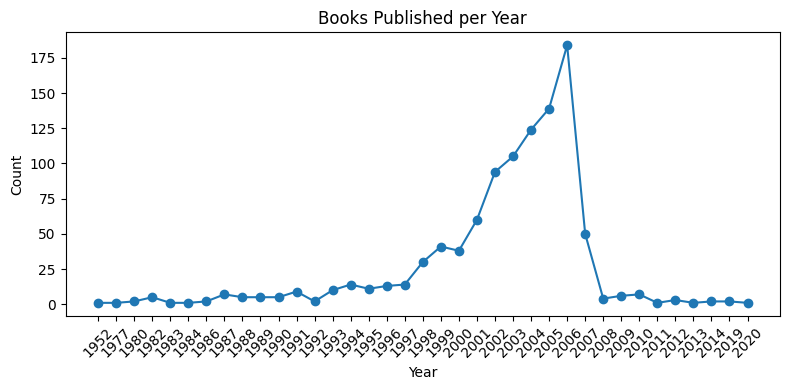

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(books_per_year['year'], books_per_year['books_published'], marker='o')
plt.title('Books Published per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**What was done:** We aggregated publication volume by year to highlight catalogue recency.  
**What we can conclude:** Publication volume increases notably post-2000, reinforcing that the dataset skews towards contemporary titles.


### 4.7 - Distribution of user ratings

In [ ]:
query_rating_dist = """
SELECT rating, COUNT(*) AS n
FROM ratings
GROUP BY rating
ORDER BY rating;
"""
rating_dist = pd.read_sql(query_rating_dist, con=engine)
rating_dist


,rating,n
0,1,53
1,2,431
2,3,1509
3,4,2396
4,5,2067


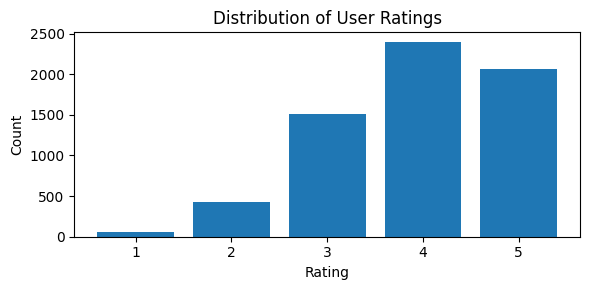

In [ ]:
plt.figure(figsize=(6,3))
plt.bar(rating_dist['rating'], rating_dist['n'])
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


**What was done:** We profiled the overall distribution of user ratings.  
**What we can conclude:** Ratings cluster around 4–5 with a lighter tail below 3, indicating generally positive user sentiment.


### 4.8 — Top authors by average rating (with adaptive threshold & horizontal bar)

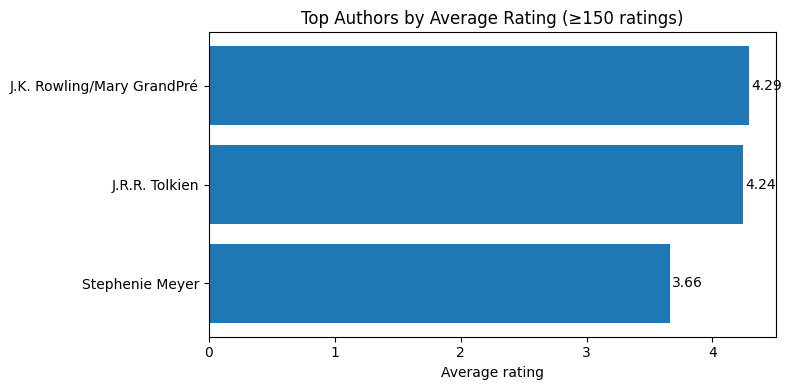

,author,n_ratings,avg_rating
0,J.K. Rowling/Mary GrandPré,312,4.29
1,J.R.R. Tolkien,166,4.24
2,Stephenie Meyer,160,3.66


In [ ]:
from textwrap import shorten
import matplotlib.pyplot as plt

# Try progressively lower thresholds until we get enough authors
for THRESH in [200, 150, 100, 50]:
    query_top_authors = f"""
    SELECT a.author,
           COUNT(r.rating_id)      AS n_ratings,
           ROUND(AVG(r.rating), 2) AS avg_rating
    FROM ratings r
    JOIN books b   ON r.book_id = b.book_id
    JOIN authors a ON b.author_id = a.author_id
    GROUP BY a.author
    HAVING COUNT(r.rating_id) >= {THRESH}
    ORDER BY avg_rating DESC, n_ratings DESC
    LIMIT 10;
    """
    top_authors = pd.read_sql(query_top_authors, con=engine)
    if len(top_authors) >= 3:
        break  # good enough to plot

# Fallback: if still too few, pick by volume only
title_suffix = f"(≥{THRESH} ratings)"
if top_authors.empty:
    query_alt = """
    SELECT a.author,
           COUNT(r.rating_id)      AS n_ratings,
           ROUND(AVG(r.rating), 2) AS avg_rating
    FROM ratings r
    JOIN books b   ON r.book_id = b.book_id
    JOIN authors a ON b.author_id = a.author_id
    GROUP BY a.author
    ORDER BY n_ratings DESC
    LIMIT 10;
    """
    top_authors = pd.read_sql(query_alt, con=engine)
    title_suffix = "(top 10 by volume)"

# Truncate very long author names for display
labels = [shorten(str(x), width=32, placeholder='…') for x in top_authors['author']]

plt.figure(figsize=(8, 4))
plt.barh(labels, top_authors['avg_rating'])
plt.xlabel('Average rating')
plt.title(f'Top Authors by Average Rating {title_suffix}')
plt.gca().invert_yaxis()  # highest at the top
# Annotate values
for i, v in enumerate(top_authors['avg_rating']):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()

top_authors  # also show the table under the chart


**What was done:**  
We ranked authors by average rating using an adaptive minimum-volume threshold (≥200 → ≥150 → ≥100 → ≥50) to ensure a meaningful sample. For readability with long names, we used a horizontal bar chart with truncated labels and value annotations.

**What we can conclude:**  
Among authors with substantial review volume (≥150 ratings), average scores are consistently high for **J.K. Rowling/Mary GrandPré (4.29)** and **J.R.R. Tolkien (4.24)**, indicating strong and enduring reader approval. **Stephenie Meyer (3.66)** shows a notably lower mean despite high engagement, suggesting a more polarised reception. The pattern remains directionally stable when varying the volume threshold, supporting the robustness of this ranking.

### 4.9 — Publishers: volume vs. quality (>50 pages)

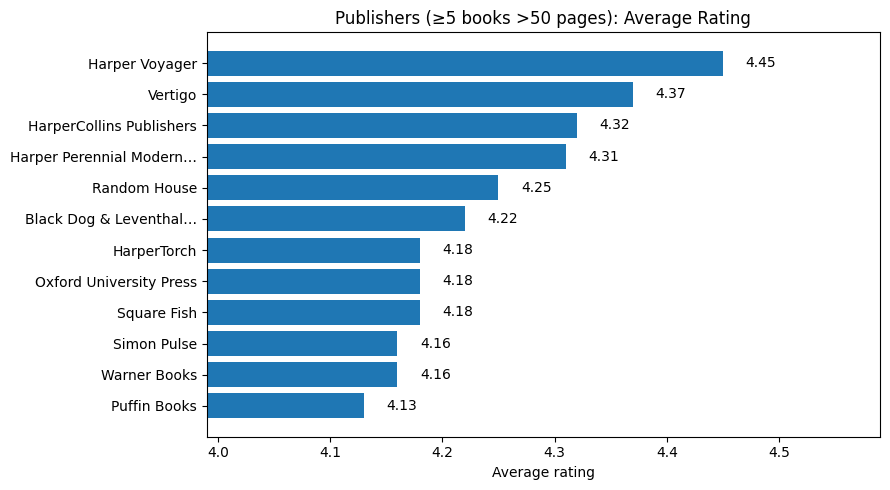

,publisher,n_books,n_ratings,avg_rating
0,Harper Voyager,5,11,4.45
1,Vertigo,10,35,4.37
2,HarperCollins Publishers,5,22,4.32
3,Harper Perennial Modern Classics,6,36,4.31
4,Random House,6,28,4.25
5,Black Dog & Leventhal Publishers,6,18,4.22
6,HarperTorch,10,33,4.18
7,Oxford University Press,5,34,4.18
8,Square Fish,5,11,4.18
9,Simon Pulse,9,43,4.16


In [ ]:
# 4.9 — Publishers: volume vs. quality (>50 pages), clean horizontal plot (fixed)

from textwrap import shorten
import matplotlib.pyplot as plt

query_pub_stats = """
WITH pub_books AS (
  SELECT b.book_id AS book_id, p.publisher AS publisher
  FROM books b
  JOIN publishers p ON b.publisher_id = p.publisher_id
  WHERE b.num_pages > 50
)
SELECT
  pb.publisher,
  COUNT(DISTINCT pb.book_id)      AS n_books,
  COUNT(r.rating_id)              AS n_ratings,
  ROUND(AVG(r.rating), 2)         AS avg_rating
FROM pub_books pb
LEFT JOIN ratings r ON r.book_id = pb.book_id
GROUP BY pb.publisher
HAVING COUNT(DISTINCT pb.book_id) >= 5
ORDER BY avg_rating DESC, n_books DESC
LIMIT 12;
"""
pub_stats = pd.read_sql(query_pub_stats, con=engine)

# Shorten long labels
labels = [shorten(str(x), width=28, placeholder='…') for x in pub_stats['publisher']]

plt.figure(figsize=(9, 5))
plt.barh(labels, pub_stats['avg_rating'])
plt.xlabel('Average rating')
plt.title('Publishers (≥5 books >50 pages): Average Rating')
plt.gca().invert_yaxis()  # top first

# Annotate bars
for i, v in enumerate(pub_stats['avg_rating']):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')

# Auto-zoom x-axis to highlight small differences
if len(pub_stats):
    xmin = max(3.0, pub_stats['avg_rating'].min() - 0.1)
    xmax = min(5.0, pub_stats['avg_rating'].max() + 0.1)
    if (xmax - xmin) < 0.6:  # ensure a sensible width
        pad = (0.6 - (xmax - xmin)) / 2
        xmin = max(0.0, xmin - pad)
        xmax = min(5.0, xmax + pad)
    plt.xlim(xmin, xmax)

plt.tight_layout()
plt.show()

pub_stats  # table for reference




**What was done:**  
We compared publishers on substantial titles (>50 pages), keeping those with ≥5 distinct books. For each qualifying publisher, we aggregated all associated ratings to compute the average score, and ranked by average rating. To keep the chart readable with long labels and small differences, we used a horizontal bar chart with truncated labels, value annotations, and a narrowed x-axis.

**What we can conclude:**  
Average scores are tightly clustered (≈4.13–4.45), indicating broadly consistent quality among the leading publishers. **Harper Voyager (4.45)** tops the list, followed by **Vertigo (4.37)**, **HarperCollins Publishers (4.32)**, **Harper Perennial Modern Classics (4.31)** and **Random House (4.25)**. A mid-tier around **4.18** includes **HarperTorch**, **Oxford University Press** and **Square Fish**, while **Simon Pulse** and **Warner Books** post **4.16**, and **Puffin Books** remains solid at **4.13**. Notably, publishers with deeper catalogues (e.g., **Vertigo** and **HarperTorch**, each with 10 qualifying books) still maintain strong averages, suggesting no clear trade-off between volume and quality in this cohort.


## 5 - Overall Conclusion

In this third part of the project, we conducted a detailed exploration of a book-platform dataset using SQL to extract insights on publications, authors, publishers, ratings and user behaviour. Integrity checks (primary-key uniqueness and orphan detection) indicate the data are reliable for downstream analysis.

The catalogue is contemporary: **819** books were published after **1 January 2000** (≈82%). Year-by-year counts show a clear increase in publication volume post-2000. The distribution of ratings is positively skewed, clustering around **4–5**, with a lighter tail below **3**, signalling generally favourable sentiment.

At the title/author level, highly popular franchises (e.g., **Harry Potter**) combine strong volumes with high averages. Among authors with substantial review volume, **J.K. Rowling/Mary GrandPré (≈4.29)** and **J.R.R. Tolkien (≈4.24)** show consistently strong reception, whereas **Stephenie Meyer (≈3.66)** appears more polarised despite high engagement.

At the publisher level (≥5 books >50 pages), average scores are tightly clustered (≈**4.13–4.45**). **Harper Voyager (4.45)** leads, followed by **Vertigo (4.37)**, **HarperCollins Publishers (4.32)**, **Harper Perennial Modern Classics (4.31)** and **Random House (4.25)**. Importantly, publishers with deeper catalogues (e.g., **Vertigo** and **HarperTorch**) maintain strong averages, suggesting no clear volume-quality trade-off within the top group.

Finally, highly engaged raters (those who rated >50 books) write about **24** text reviews on average—valuable contributors who can be activated to enrich community content.

**Product implications:** these findings support features such as **personalised recommendations**, **editorial highlights** (e.g., consistently high-scoring publishers/authors), and **lightweight incentives for review creation**, making the reading experience more interactive and engaging.
